In [1]:
from __future__ import absolute_import, division, print_function
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import nltk
from gensim.models import Phrases
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import pandas as pnd
import seaborn as sea
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plot
%matplotlib notebook
%matplotlib inline

In [2]:
#Enter the path where the text file with sentences split is located
f_name = sorted(glob.glob("C:/Users/Suraj/Desktop/CS584/Scripts/final_Programs/2011.txt"))
print("Found:")
print(f_name)

Found:
['C:/Users/Suraj/Desktop/CS584/Scripts/final_Programs/2011.txt']


In [3]:
corpus=[]
for each in f_name:
    with codecs.open(each, "r", "utf-8") as file:
        corpus+=file.readlines()
print(corpus[0])

direct-acting antivirals (daas) for treatment of chronic hepatitis c virus (hcv) infection can cause drug-drug interactions (ddis) with combination antiretroviral therapy (cart) and non-cart co-medication.



In [4]:
def sentence_to_word(word):
    remove_unwanted_chars = re.sub("[^a-zA-Z]"," ", word)
    final_word = remove_unwanted_chars.split()
    return final_word

In [5]:
final_sentences = []
for sentence in corpus:
    if len(sentence) > 0:
        final_sentences.append(sentence_to_word(sentence))


In [6]:
print(corpus[1])
print(sentence_to_word(corpus[1]))

we mapped how physicians manage ddis between daas and co-medication and analysed treatment outcomes.

['we', 'mapped', 'how', 'physicians', 'manage', 'ddis', 'between', 'daas', 'and', 'co', 'medication', 'and', 'analysed', 'treatment', 'outcomes']


In [7]:
count_the_tokens = sum([len(sentence) for sentence in final_sentences])
print("The corpus contains {0:,} tokens".format(count_the_tokens))

The corpus contains 12,914,514 tokens


In [8]:
#Converting split mulit words into single words. i.e. for example "New" "York" is converted to "New_York"
bigram = Phrases(final_sentences, min_count=5, threshold=10)

#Build a word2vec model for each time period files
abs2vec2011_plus = w2v.Word2Vec(
	sg=1,                  #Using Skip-gram model
    negative=10,           #Number of samples to compare negative sampling 
	alpha=0.005,           #Neural networds learning rate
    seed=1,                #Seed for the RNG, to make the results reproducible.
    workers=multiprocessing.cpu_count(),   # Number of threads to run in parallel.
    size=200,              #N-dimensions of vector
    min_count=5,           # Minimum word count threshold.
    window=2,              # Context window length.
    sample=1e-4            # Downsample setting for frequent words.
)


In [9]:
#Building the vocabulary
abs2vec2011_plus.build_vocab(bigram[final_sentences])

print("Word2Vec vocabulary length:", len(abs2vec2011_plus.wv.vocab))

Word2Vec vocabulary length: 57270


In [10]:
#Training the word2vec model
abs2vec2011_plus.train(bigram[final_sentences], total_examples=abs2vec2011_plus.corpus_count, epochs=abs2vec2011_plus.iter)

6466079

In [11]:
#Save the trained word2vec model in a directory
if not os.path.exists("model_saved"):
    os.makedirs("model_saved")
abs2vec2011_plus.save(os.path.join("model_saved", "abs2vec2011_plus.w2v"))

In [2]:
#Load the model to do analysis
abs2vec2011_plus = w2v.Word2Vec.load(os.path.join("model_saved", "abs2vec2011_plus.w2v"))

In [13]:
#Get the most similar values to a word of choice
print(abs2vec2011_plus.most_similar("hiv"))


[('infection', 0.9705164432525635), ('chronic', 0.9704685211181641), ('hsv', 0.9702824950218201), ('acute', 0.9663132429122925), ('progression', 0.9651920795440674), ('co_infection', 0.9651883244514465), ('herpes_simplex', 0.965083122253418), ('coinfection', 0.9647707343101501), ('tuberculosis', 0.9621977806091309), ('acquired_immunodeficiency', 0.9620643854141235)]


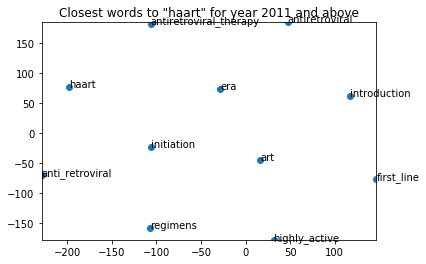

In [4]:
#Selecting the words similar to the given word and plotting the points after dimensionality reduction using t-SNE. 
model=abs2vec2011_plus
word='haart'
plot_title='Closest words to "haart" for year 2011 and above'
arr = np.empty((0,200), dtype='f')
label_words = [word]

# get close words
similar_words = model.similar_by_word(word)
    
# add the vector for each of the closest words to the array
arr = np.append(arr, np.array([model[word]]), axis=0)
for word_value in similar_words:
    word_vector = model[word_value[0]]
    label_words.append(word_value[0])
    arr = np.append(arr, np.array([word_vector]), axis=0)
       
# find tsne coords for 2 dimensions
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
X = tsne.fit_transform(arr)

x_axis = X[:, 0]
y_axis = X[:, 1]
# display scatter plot
plot.scatter(x_axis, y_axis)

for label, x, y in zip(label_words, x_axis, y_axis):
        plot.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plot.xlim(x_axis.min()+0.00005, x_axis.max()+0.00005)
plot.ylim(y_axis.min()+0.00005, y_axis.max()+0.00005)
plot.title(plot_title)
plot.show()
